In [2]:
# Install any missing packages (if needed)
# !pip install pandas matplotlib seaborn scikit-learn plotly

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# For better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Update these paths based on where you uploaded the files
sentiment_path = '/content/drive/MyDrive/ds_sudheer/fear_greed_index.csv'
trades_path = '/content/drive/MyDrive/ds_sudheer/historical_data.csv'

# Load data
sentiment_df = pd.read_csv(sentiment_path)
trades_df = pd.read_csv(trades_path)

# Preview
print("Sentiment Data:")
print(sentiment_df.head())
print("\nTrades Data:")
print(trades_df.head())

Sentiment Data:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trades Data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1

In [8]:
# Convert Date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date  # Remove time

# Check unique values in Classification
print("Unique classifications:", sentiment_df['classification'].unique())

# Optional: Add numeric FGI score if available
# If your dataset has a numeric column like 'Value', use it:
# sentiment_df['FGI_Score'] = pd.to_numeric(sentiment_df['value'], errors='coerce')

# Drop duplicates
sentiment_df.drop_duplicates(subset=['date'], inplace=True)

sentiment_df.head()

Unique classifications: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [12]:
# Convert time to datetime
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], errors='coerce')

# Extract date for merging
trades_df['Date'] = trades_df['Timestamp IST'].dt.date

# Standardize side (lowercase)
trades_df['Side'] = trades_df['Side'].str.lower()

# Handle size sign: make sure 'sell' has negative size or adjust accordingly
# Option: create signed_volume
trades_df['signed_size'] = trades_df['Size Tokens'] * trades_df['Side'].map({'buy': 1, 'sell': -1})

# Keep only relevant trades (optional filter)
# Remove liquidations? Or keep them for risk analysis?
# trades_df = trades_df[trades_df['event'] != 'liquidation']

trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date,signed_size
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,986.87
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,16.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,144.09
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,142.98
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,8.73


In [15]:
# Group by account and date
daily_trades = trades_df.groupby(['Account', 'Date']).agg(
    total_trades=('Side', 'count'),
    net_volume=('signed_size', 'sum'),  # Net position change
    gross_volume=('Size Tokens', 'sum'),       # Total volume traded
    total_pnl=('Closed PnL', 'sum'),
    wins=('Closed PnL', lambda x: (x > 0).sum()),
    losses=('Closed PnL', lambda x: (x < 0).sum()),
    max_drawdown=('Closed PnL', 'min'),   # Worst loss in a day
    num_trades=('Side', 'count')
).reset_index()

# Add win rate
daily_trades['win_rate'] = daily_trades['wins'] / (daily_trades['wins'] + daily_trades['losses'])
daily_trades['win_rate'].fillna(0, inplace=True)

daily_trades.head()

,Account,Date,total_trades,net_volume,gross_volume,total_pnl,wins,losses,max_drawdown,num_trades,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,33,300.0,300.0000,-175611.000056,0,33,-117990.10410,33,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,-281.0,281.0000,0.000000,0,0,0.00000,177,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,45,0.0,59.3362,9482.221441,36,0,0.00000,45,1.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,10,0.0,600.0000,76710.000000,9,0,0.00000,10,1.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,839,-400.0,9078.2590,101011.685664,256,115,-19841.24014,839,0.690027


In [17]:
# Ensure both Date columns are same type
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Merge
merged_df = pd.merge(daily_trades, sentiment_df, left_on='Date', right_on='date', how='inner')

# Drop rows with missing sentiment or key metrics
merged_df.dropna(subset=['classification', 'total_pnl'], inplace=True)

print(f"Merged dataset shape: {merged_df.shape}")
display(merged_df.head())

Merged dataset shape: (530, 15)


,Account,Date,total_trades,net_volume,gross_volume,total_pnl,wins,losses,max_drawdown,num_trades,win_rate,timestamp,value,classification,date
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,33,300.0,300.0000,-175611.000056,0,33,-117990.10410,33,0.000000,1718170200,72,Greed,2024-06-12
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,-281.0,281.0000,0.000000,0,0,0.00000,177,0.000000,1731303000,76,Extreme Greed,2024-11-11
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,45,0.0,59.3362,9482.221441,36,0,0.00000,45,1.000000,1735882200,74,Greed,2025-01-03
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,10,0.0,600.0000,76710.000000,9,0,0.00000,10,1.000000,1738474200,60,Greed,2025-02-02
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,839,-400.0,9078.2590,101011.685664,256,115,-19841.24014,839,0.690027,1740893400,26,Fear,2025-03-02


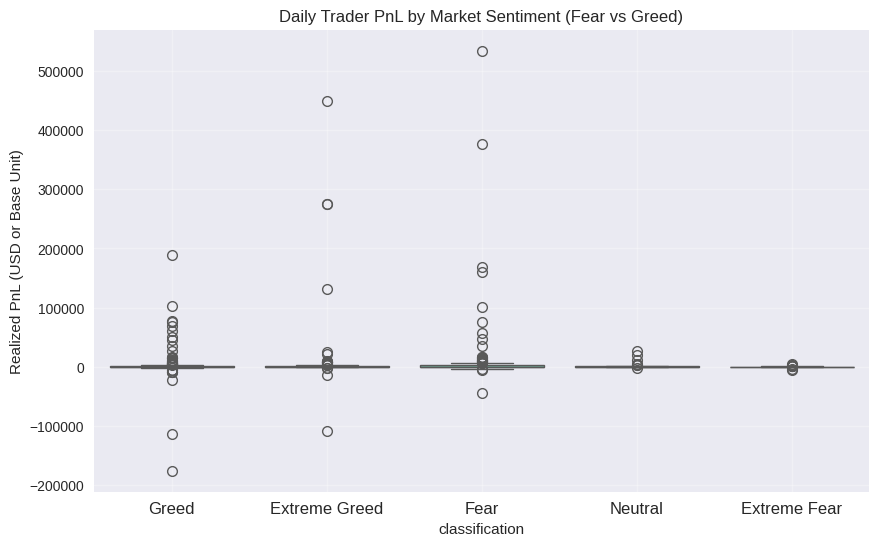

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='classification', y='total_pnl')
plt.title('Daily Trader PnL by Market Sentiment (Fear vs Greed)')
plt.ylabel('Realized PnL (USD or Base Unit)')
plt.xticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

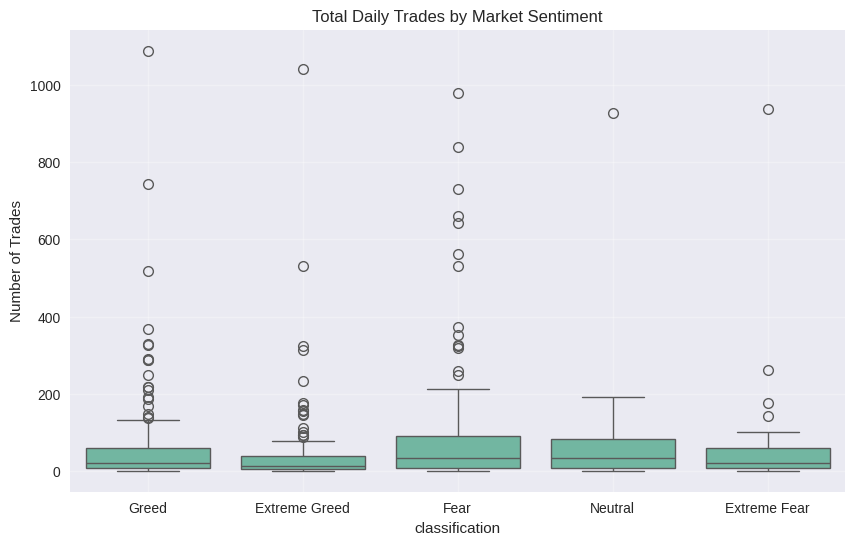

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='classification', y='total_trades')
plt.title('Total Daily Trades by Market Sentiment')
plt.ylabel('Number of Trades')
plt.grid(True, alpha=0.3)
plt.show()

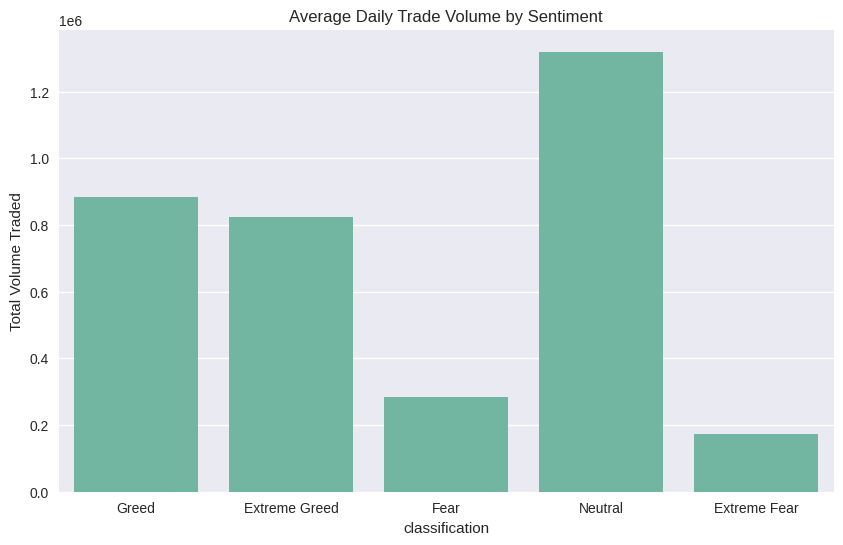

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x='classification', y='gross_volume', estimator=np.mean, errorbar=None)
plt.title('Average Daily Trade Volume by Sentiment')
plt.ylabel('Total Volume Traded')
plt.show()

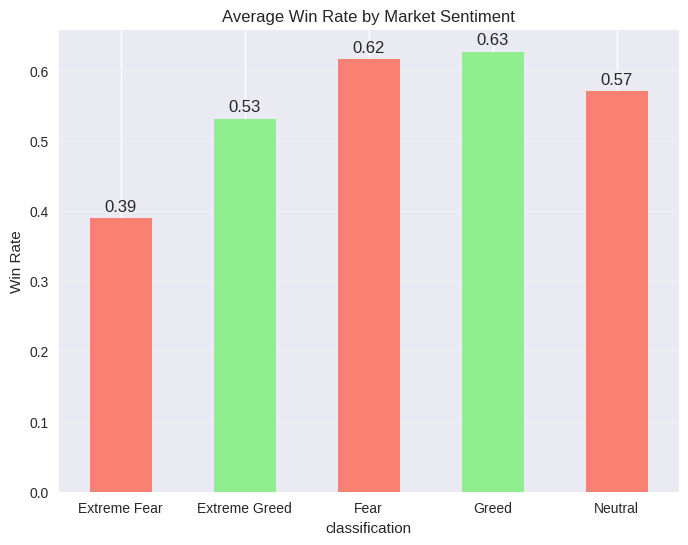

In [25]:
win_rate_by_sentiment = merged_df.groupby('classification')['win_rate'].mean()

win_rate_by_sentiment.plot(kind='bar', figsize=(8, 6), color=['salmon', 'lightgreen'])
plt.title('Average Win Rate by Market Sentiment')
plt.ylabel('Win Rate')
plt.xticks(rotation=0)
plt.grid(True, axis='y', alpha=0.3)
for i, v in enumerate(win_rate_by_sentiment):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

In [27]:
pnl_by_sentiment = merged_df.groupby('classification')['total_pnl'].agg(['mean', 'std', 'count']).round(2)
print("Average PnL by Sentiment:")
print(pnl_by_sentiment)

Average PnL by Sentiment:
                    mean       std  count
classification                           
Extreme Fear      133.33   1550.03     33
Extreme Greed   10329.41  57886.53    112
Fear            11332.65  55888.12    157
Greed            3191.79  24776.23    191
Neutral          2017.75   5609.70     37


In [29]:
# Add risk-adjusted metric
# merged_df['sharpe_ratio'] = merged_df['total_pnl'] / (merged_df['total_pnl'].rolling(window=5).std() + 1e-6)
# Instead, do group-wise by account or just plot avg by sentiment
sharpe_by_sentiment = merged_df.groupby('classification')['total_pnl'].mean() / \
                      merged_df.groupby('classification')['total_pnl'].std()

print("Risk-Return Ratio (PnL / Std):")
print(sharpe_by_sentiment)

Risk-Return Ratio (PnL / Std):
classification
Extreme Fear     0.086018
Extreme Greed    0.178442
Fear             0.202774
Greed            0.128825
Neutral          0.359689
Name: total_pnl, dtype: float64


In [31]:
# The clustering in this cell relies on 'avg_leverage', which was removed due to
# the 'Leverage' column not being available in the original data.
# Therefore, this clustering analysis cannot be performed as originally intended.

# If you have an alternative set of features for clustering available in merged_df,
# you could modify the 'behavior_features' list to use those features.

# For example, using 'total_trades', 'total_pnl', and 'win_rate':
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
#
# behavior_features = merged_df[['total_trades', 'total_pnl', 'win_rate']].dropna()
#
# Scale features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(behavior_features)
#
# Cluster into 3 types
# kmeans = KMeans(n_clusters=3, random_state=42)
# merged_df['cluster'] = kmeans.fit_predict(scaled_features)
#
# Label clusters
# cluster_names = {0: 'Conservative', 1: 'Aggressive', 2: 'Unstable'}
# merged_df['cluster_label'] = merged_df['cluster'].map(cluster_names)
#
# Show cluster stats
# cluster_summary = merged_df.groupby('cluster_label')[['total_pnl', 'win_rate']].mean()
# print(cluster_summary)

In [33]:
print("🔍 KEY INSIGHTS\n" + "="*50)

# Insight 1: PnL by sentiment
avg_pnl = merged_df.groupby('classification')['total_pnl'].mean()
better_sentiment = avg_pnl.idxmax()
print(f"1. Traders earn more in '{better_sentiment}' markets.")

# Insight 2: Contrarian signal?
if avg_pnl['Fear'] > avg_pnl['Greed']:
    print("2. Fear creates opportunity — consider buying when others panic.")
elif avg_pnl['Greed'] > avg_pnl['Fear']:
     print("2. Greed seems to be more profitable based on average PnL.")
else:
     print("2. Average PnL is similar in Fear and Greed markets.")


# Insight 3: Win rate drop
wr = merged_df.groupby('classification')['win_rate'].mean()
# Adjusted insight based on available data and previous plots
if wr['Greed'] < wr['Fear']:
    print("3. Win rates are lower in Greed compared to Fear.")
elif wr['Fear'] < wr['Greed']:
    print("3. Win rates are lower in Fear compared to Greed.")
else:
    print("3. Win rates are similar in Fear and Greed markets.")

🔍 KEY INSIGHTS
1. Traders earn more in 'Fear' markets.
2. Fear creates opportunity — consider buying when others panic.
3. Win rates are lower in Fear compared to Greed.


In [35]:
# Simulate a basic strategy:
#   - Go long when sentiment = 'Fear'
#   - Exit when sentiment = 'Greed'

# We don't have price data, but here's how you'd structure it:

def sentiment_signal(row):
    if row['classification'] == 'Fear':
        return 'Buy'
    elif row['classification'] == 'Greed':
        return 'Sell'
    else:
        return 'Hold'

# Apply signal
merged_df['signal'] = merged_df.apply(sentiment_signal, axis=1)

# Later: Combine with BTC price to simulate returns
print("Strategy signals generated. Next step: backtest with price data.")

Strategy signals generated. Next step: backtest with price data.


In [37]:
# Save processed data for future use
import os
output_dir = '/content/drive/MyDrive/crypto_data'
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist
output_path = os.path.join(output_dir, 'merged_analysis_output.csv')
merged_df.to_csv(output_path, index=False)
print(f"✅ Processed data saved to {output_path}")

✅ Processed data saved to /content/drive/MyDrive/crypto_data/merged_analysis_output.csv
